<div class="alert alert-block alert-info">
<b>Deadline:</b> April 24, 2024 (Wednesday) 23:00
</div>

# Exercise 1. Recurrent relational network

The goal of this exercise is to get familiar with graph neural networks.

We will implement a simplified version of the recurrent relational network proposed in [this paper](http://papers.nips.cc/paper/7597-recurrent-relational-networks.pdf).

We recommend you to use a machine with GPU for solving this exercise. Training on CPU will take much longer.

In [142]:
skip_training = False  # Set this flag to True before validation and submission

In [143]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [144]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tools
#import tests

In [145]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [146]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
#device = torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [147]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

The dataset is a set of sudoku puzzles with solutions obtained from [here](https://github.com/locuslab/SATNet).

In [148]:
import data
trainset = data.Sudoku(data_dir, train=True)
testset = data.Sudoku(data_dir, train=False)

x, y = trainset[0]
print(x.shape, y.shape)

torch.Size([81, 9]) torch.Size([81])


We can visualize the data in the following way.

In [149]:
def sudoku_to_labels(x):
    """Convert one-hot coded sudoku puzzles to labels. -1 corresponds to missing labels.
    
    Args:
      x of shape (n_rows=9, n_colums=9, n_digits=9): Tensor with a sudoku board. The digits are one-hot coded.
                  Cells with unknown digits have all zeros along the third dimension.
    """
    assert x.shape == torch.Size([9, 9, 9]), "Wrong shape {}".format(x.shape)
    is_filled = x.sum(dim=2)
    y = x.argmax(dim=2)
    y[~is_filled.bool()] = -1
    return y

In [150]:
print(sudoku_to_labels(x.view(9, 9, 9)))

tensor([[ 5,  6, -1, -1, -1, -1, -1, -1,  4],
        [-1, -1,  2, -1,  3, -1, -1,  7,  1],
        [-1,  3, -1, -1, -1,  4,  0,  2,  5],
        [-1, -1, -1,  6,  2, -1, -1,  8, -1],
        [ 2, -1,  3,  1, -1,  5, -1,  6, -1],
        [-1, -1,  0, -1,  8, -1,  5, -1, -1],
        [ 4, -1,  8, -1, -1,  7, -1, -1, -1],
        [-1, -1, -1,  8,  4, -1,  1, -1,  7],
        [-1, -1, -1,  0,  1,  6,  3, -1, -1]])


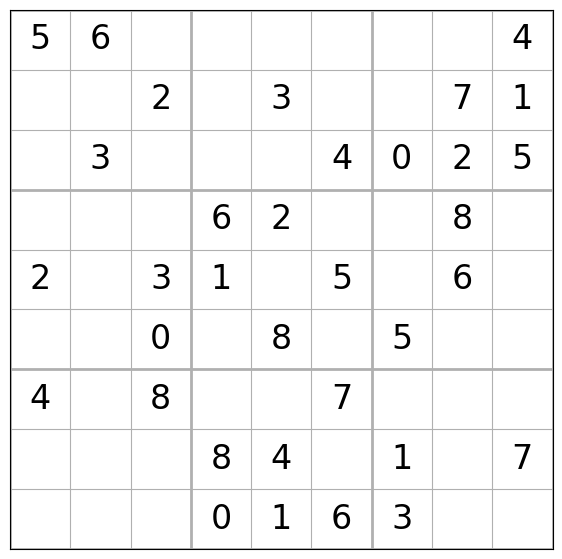

In [151]:
tools.draw_sudoku(x.view(9, 9, 9), logits=False)

## Graph

We describe each sudoku puzzle as a graph in which each node corresponds to one of the 9*9=81 cells in the puzzle. Each node is connected to 8+8+8-4=20 other nodes:
* 8 nodes that correspond to other cells in the same row
* 8 nodes that correspond to other cells in the same column
* 8 nodes that correspond to other cells in the same $3\times 3$ box
* 4 cells appear both in a $3\times 3$ box and in the same row or column.

In this exercise, we decribe a graph as a set of edges. Each edge is a pair (`src_id`, `dst_id`) where `src_id` is the id of the source node and `dst_id` is the id of the destination node. In the cell below, your task is to describe such a graph by producing two lists:
* a list of source node ids `src_id` of all edges
* a list of destination node ids `dst_id` of all edges

Notes:

* To be consistent with the training data set, we need to use node ids from 0 and 80 according to the following order:
```
[ 0,  1,  2,  3,  4,  5,  6,  7,  8]
[ 9, 10, 11, 12, 13, 14, 15, 16, 17]
[18, 19, 20, 21, 22, 23, 24, 25, 26]
[27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44]
[45, 46, 47, 48, 49, 50, 51, 52, 53]
[54, 55, 56, 57, 58, 59, 60, 61, 62]
[63, 64, 65, 66, 67, 68, 69, 70, 71]
[72, 73, 74, 75, 76, 77, 78, 79, 80]
```
* This function is called only once before training. Therefore, you do not need to optimize its execution time.

In [152]:
def cellNeighbours(node_id, node_ids):
    
    ret = []
    col = node_id % 9
    row = node_id // 9
    #colPairs = [(0,1,2),(3,4,5),(6,7,8)]
    #rowPairs = [(0,1,2),(3,4,5),(6,7,8)]
    for id in node_ids:
        if id // 9 == row or id % 9 == col:
            # Skip cells in the same row or column 
            # To avoid duplicate edges in the result
            continue
        if (id % 9) // 3 == col // 3 and (id // 9) // 3 == row // 3:
            ret.append(id)
    return ret
       
def rowNeighbours(node_id, node_ids):
    ret = []
    row = node_id // 9
    for id in node_ids:
        if id != node_id and id // 9 == row:
            ret.append(id)
    return ret

def colNeighbours(node_id, node_ids):
    ret = []
    col = node_id % 9
    for id in node_ids:
        if id != node_id and id % 9 == col:
            ret.append(id)
    return ret
   

def sudoku_edges():
    """Generate edges of the graph describing the sudoku puzzle.
    
    Returns:
      src_ids: LongTensor of length 1620 with source node ids of all the edges in the graph.
      dst_ids: LongTensor of length 1620 with destination node ids of all the edges in the graph
    
    Note: Our tests assume that node ids are between 0 and 80. Please follow this convention.
    """
    node_ids = torch.arange(81)
    src_ids = []
    dst_ids = []
    #edges = []
    for id in node_ids:
        cols = colNeighbours(id, node_ids)
        rows = rowNeighbours(id, node_ids)
        cells = cellNeighbours(id, node_ids)

        for col in cols:
            src_ids.append(id)
            dst_ids.append(col)
            #edges.append((id, col))

        for row in rows:
            src_ids.append(id)
            dst_ids.append(row)
            #edges.append((id, row))

        for cell in cells:
            src_ids.append(id)
            dst_ids.append(cell)
            #edges.append((id, cell))
    
    return torch.LongTensor(src_ids), torch.LongTensor(dst_ids)

In [153]:
sudoku_src_ids, sudoku_dst_ids = sudoku_edges()
print('Number of edges in each sudoku graph: %d' % len(sudoku_src_ids))
assert sudoku_src_ids.dtype == torch.long and sudoku_dst_ids.dtype == torch.long
assert len(sudoku_src_ids) == len(sudoku_dst_ids), "The number of source and destination nodes should be same."
assert len(sudoku_src_ids) == 1620, "Wrong number of edges ({}), expected: 1620".format(len(sudoku_src_ids))
assert min(sudoku_src_ids) == 0 and max(sudoku_src_ids) == 80, "Node ids should be between 0 and 80"
assert min(sudoku_dst_ids) == 0 and max(sudoku_dst_ids) == 80, "Node ids should be between 0 and 80"

Number of edges in each sudoku graph: 1620


## Custom data loader

We first create a custom data loader to process a mini-batch of graphs (in parallel) to compute the derivatives wrt the parameters of the graph neural network. To do that, **we transform a mini-batch of graphs to one large graph without interconnecting edges between the subgraphs corresponding to individual examples in the mini-batch.** We do this using a custom collate function that you need to implement in the cell below.

In [154]:
source_edges, target_edges = sudoku_edges()

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (inputs, targets),
          inputs of shape (n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
              in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
          targets of shape (n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).

    Returns:
      inputs of shape (batch_size*n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
          in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
      targets of shape (batch_size*n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).
      src_ids of shape (batch_size*1620): LongTensor of source node ids for each edge in the large graph.
          The source ids should be between 0 and batch_size * 81.
      dst_ids of shape (batch_size*1620): LongTensor of destination node ids for each edge in the large graph.
          The destination ids should be between 0 and batch_size * 81.
    """
    
    inputs = torch.cat([x[0] for x in list_of_samples], dim=0)
    targets = torch.cat([x[1] for x in list_of_samples], dim=0)

    src_ids = []
    dst_ids = []
    
    for k in range(0, len(list_of_samples)):
        for i in source_edges:
            src_ids.append(k*81+i)
        for i in target_edges:
            dst_ids.append(k*81+i)
    src_ids = torch.LongTensor(src_ids)
    dst_ids = torch.LongTensor(dst_ids)

    return inputs, targets, src_ids, dst_ids

In [155]:
def test_collate_shapes():
    batch_size = 2
    n_nodes = 81
    inputs, targets, src_ids, dst_ids = collate([trainset[0], trainset[1]])
    assert inputs.shape == torch.Size([batch_size*n_nodes, 9]), f"Bad inputs.shape: {inputs.shape}"
    assert targets.shape == torch.Size([batch_size*n_nodes]), f"Bad targets.shape: {targets.shape}"
    assert src_ids.shape == torch.Size([batch_size*1620]), f"Bad src_ids.shape: {src_ids.shape}"
    assert dst_ids.shape == torch.Size([batch_size*1620]), f"Bad dst_ids.shape: {dst_ids.shape}"
    assert min(src_ids) == 0 and max(src_ids) == batch_size*81-1
    assert min(dst_ids) == 0 and max(dst_ids) == batch_size*81-1
    print('Success')

test_collate_shapes()

Success


In [156]:
trainloader = DataLoader(trainset, batch_size=16, collate_fn=collate, shuffle=True)
testloader = DataLoader(testset, batch_size=16, collate_fn=collate, shuffle=False)

<img src="recurrent_rn.png" width=300 style="float: right;">

# Graph neural network

You need to implement a graph neural network in the cell below. Its forward function consists of `n_iters` iterations with the following steps:
* For each node, compute the messages from all its neighbors using the message network (see description below).
* For each destination node, aggregate (by summation) all the messages sent by its neighbors. You may find it useful to use function [index_add_](https://pytorch.org/docs/stable/generated/torch.Tensor.index_add_.html#torch.Tensor.index_add_) for that.
* The aggregated messages are concatenated with the node inputs to form the inputs of the gated recurrent units (GRUs) whose states represent the states of the nodes. The node inputs are one-hot coded digits 1-9 of the sudoku puzzle, a missing digit is encoded with all zeros. 
* The states of the GRUs are updated using the standard GRU computations.
* The states of each graph node are linearly combined to compute the output of the corresponding node at the current iteration.

**Note that since we combine all graphs in the mini-batch into a single graph using `collate()` function, we do not need to care about batches in our implementation of GNN.**


### Message network

* All messages are computed with the same message network (shared parameters).
* The message network takes as inputs the states of the source node and the states of the destination node and produces a vector with `n_edge_features`.
* We used as the message network a multilayer perceptron (MLP) network with the following architecture:
  * hidden layer with 96 neurons and ReLU nonlinearity
  * hidden layer with 96 neurons and ReLU nonlinearity
  * output layer with `n_edge_features` output features.
* **Important:** Our tests assume that the message network is defined as an attribute called `msg_net`, that is it can be accessed as follows:
```
gnn = GNN()
print(gnn.msg_net)
```

Notes:

* Please initialize the node states (before the first iteration) with all zeros.
* The messages computed in the first iteration are not informative because they combine zero states.
* For faster training, try to minimize the number of for-loops in your implementation.
* **Your implementation of the GNN should work with any graph topologies, not necessarily sudoku. Please do not assume any dimensions specific to the sudoku graph.**

In [157]:
class GNN(nn.Module):
    def __init__(self, n_iters=7, n_node_features=10, n_node_inputs=9, n_edge_features=11, n_node_outputs=9):
        """
        Args:
          n_iters: Number of graph iterations.
          n_node_features: Number of features in the states of each node.
          n_node_inputs: Number of inputs to each graph node (on each graph iteration).
          n_edge_features: Number of features in the messages sent along the edges of the graph (produced
              by the message network).
          n_node_outputs: Number of outputs produced by at each node of the graph.
        """
        super(GNN, self).__init__()
        
        self.n_iters = n_iters
        self.n_node_features = n_node_features
        self.n_node_inputs = n_node_inputs
        self.n_edge_features = n_edge_features
        self.n_node_outputs = n_node_outputs
        
        self.gru = nn.GRU(n_node_inputs + n_edge_features, n_node_features)
        #self.gru = nn.GRU(n_node_features, n_node_inputs + n_edge_features)

        self.msg_net = nn.Sequential(
            nn.Linear(2*n_node_features, 96), 
            nn.ReLU(),
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, n_edge_features),
        )

        self.out = nn.Linear(n_node_features, n_node_outputs)

    def forward(self, node_inputs, src_ids, dst_ids):
        """
        Args:
          node_inputs of shape (n_nodes, n_node_inputs): Tensor of inputs to every node of the graph.
          src_ids of shape (n_edges): Indices of source nodes of every edge.
          dst_ids of shape (n_edges): Indices of destination nodes of every edge.
          
        Returns:
          outputs of shape (n_iters, n_nodes, n_node_outputs): Outputs of all the nodes at every iteration of the
              graph neural network.
        """
        n_nodes = node_inputs.size(0)
        node_states = torch.zeros(n_nodes, self.n_node_features, device=node_inputs.device)

        outputs = []

        for i in range(self.n_iters):
            messages = torch.zeros(n_nodes, self.n_edge_features, device=node_inputs.device)

            msg_input = torch.cat([node_states[src_ids], node_states[dst_ids]], dim=1)
            msg = self.msg_net(msg_input)

            messages.index_add_(0, dst_ids, msg)

            gru_input = torch.cat([node_inputs, messages], dim=1)

            _, node_states = self.gru(gru_input.unsqueeze(0), node_states.unsqueeze(0))
            node_states = node_states.squeeze(0)
            output = self.out(node_states)
            outputs.append(output.unsqueeze(0))

        outputs = torch.cat(outputs, dim=0)
        return outputs

In [158]:
# Shape tests of the message network
def test_GNN_msg_net():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81
    n_edges = len(src_ids)
    n_node_features = 5
    n_edge_features = 6

    gnn = GNN(n_iters=7, n_node_features=n_node_features, n_edge_features=n_edge_features)
    msg_net_inputs = torch.zeros(n_edges, 2*n_node_features)
    assert hasattr(gnn, 'msg_net'), "Cannot find the message network."
    messages = gnn.msg_net(msg_net_inputs)  # [n_edges, n_edge_features]
    assert messages.shape == torch.Size([n_edges, n_edge_features]), f"Bad messages.shape: {messages.shape}"
    print('Success')

test_GNN_msg_net()

Success


In [159]:
# Shape tests
def test_GNN_shape():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81

    gnn = GNN(n_iters=7)
    node_inputs = torch.zeros([n_nodes, 9])
    outputs = gnn(node_inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
    assert outputs.shape == torch.Size([gnn.n_iters, n_nodes, 9]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_GNN_shape()

Success


In [160]:
# Test of GNN.forward()
def test_GNN_forward(GNN):
    with torch.no_grad():
        src_ids = torch.LongTensor([0, 1, 0])
        dst_ids = torch.LongTensor([1, 2, 2])
        n_edges = len(src_ids)

        gnn = GNN(n_iters=2, n_node_inputs=1, n_node_features=2, n_edge_features=3, n_node_outputs=2)
        class MyMsgNet(nn.Module):
            def forward(self, msg_net_inputs):
                shape = list(msg_net_inputs.size())
                shape[-1] = gnn.n_edge_features
                messages = torch.ones(*shape)
                return messages
        if isinstance(gnn.msg_net, nn.Module):
            gnn.msg_net = nn.Sequential(MyMsgNet())
            # nn.Sequential() is to handle a for loop over msg_net layers :)
        else:
            gnn.msg_net = lambda x: MyMsgNet.forward(None, x)
        
        def set_weights(gnn):
            for name, module in gnn.named_modules():
                if isinstance(module, (nn.GRU, nn.GRUCell)):
                    if isinstance(module, nn.GRU):
                        weight_ih = module.weight_ih_l0
                        weight_hh = module.weight_hh_l0
                    else:
                        weight_ih = module.weight_ih
                        weight_hh = module.weight_hh
                    
                    weight_ih.data.fill_(0)
                    weight_ih.data[:2, :].fill_(0.1)   # reset
                    weight_ih.data[2:4, :].fill_(0.1)  # update
                    weight_ih.data[4:, :].fill_(1)   # new value
                    # Since the weights are all equal, we do not need to care about the order of the inputs

                    weight_hh.data.fill_(0)
                    weight_hh.data[1, :].fill_(0.1)   # reset
                    weight_hh.data[2, :].fill_(-0.1)   # reset
                    weight_hh.data[2:4, 1].fill_(0.1) # update
                    weight_hh.data[4:, 1].fill_(0.1)   # new value
                    
                    if module.bias == True:
                        if isinstance(module, nn.GRU):
                            bias_ih = module.bias_ih_l0
                            bias_hh = module.bias_hh_l0
                        else:
                            bias_ih = module.bias_ih
                            bias_hh = module.bias_hh
                                
                        bias_ih.data.fill_(0)
                        bias_hh.data.fill_(0)

                elif isinstance(module, nn.Linear) and (module.in_features == 2) and (module.out_features == 2):
                    module.weight.data = torch.eye(2)
                    module.bias.data.fill_(0)

        set_weights(gnn)
        node_inputs = torch.Tensor([1, 2, 3]).view(3, 1)
        outputs = gnn.forward(node_inputs, src_ids, dst_ids)  # [n_iters, n_nodes, n_node_outputs]
        expected = torch.tensor([
            [[0.3618, 0.3618],
             [0.3775, 0.3775],
             [0.2891, 0.2891]],
            [[0.5554, 0.5519],
             [0.6125, 0.6070],
             [0.4946, 0.4904]]
        ])
        print('outputs:\n', outputs)
        print('expected:\n', expected)

        assert torch.allclose(outputs, expected, atol=1e-04) or \
               torch.allclose(outputs, F.log_softmax(outputs, dim=-1), atol=1e-04) or \
               torch.allclose(outputs, F.softmax(outputs, dim=-1), atol=1e-04)
        print('Success')
        
test_GNN_forward(GNN)

outputs:
 tensor([[[0.3618, 0.3618],
         [0.3775, 0.3775],
         [0.2891, 0.2891]],

        [[0.5554, 0.5519],
         [0.6125, 0.6070],
         [0.4946, 0.4904]]])
expected:
 tensor([[[0.3618, 0.3618],
         [0.3775, 0.3775],
         [0.2891, 0.2891]],

        [[0.5554, 0.5519],
         [0.6125, 0.6070],
         [0.4946, 0.4904]]])
Success


## Train the network

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* 30 epochs is usually enough for training to converge.
* The loss should be the mean of the classification losses computed at **every** GNN iteration. This way you encourage the GNN to find the correct solution with as few iterations as possible.

Hints:
* The training loss at convergence can reach 0.25. The classification loss computed after the **last** GNN iteration should be close to 0.
* The fraction of solved test puzzles is usually close to 1 (we will use the threshold of 0.93 in the tests).
* We recommend you to track the fraction of solved puzzles in the test set using the function below.

In [161]:
# Create network
gnn = GNN()
gnn.to(device)

GNN(
  (gru): GRU(20, 10)
  (msg_net): Sequential(
    (0): Linear(in_features=20, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): ReLU()
    (4): Linear(in_features=96, out_features=11, bias=True)
  )
  (out): Linear(in_features=10, out_features=9, bias=True)
)

In [162]:
def fraction_of_solved_puzzles(gnn, testloader):
    with torch.no_grad():
        n_test = 0
        n_test_solved = 0
        for i, (inputs, targets, src_ids, dst_ids) in enumerate(testloader):
            # inputs is [n_nodes, 9*9, 9]
            # targets is [n_nodes]
            batch_size = inputs.size(0) // 81
            inputs, targets = inputs.to(device), targets.to(device)
            src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

            outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
            solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)

            final_solution = solution[-1].argmax(dim=3)
            solved = (final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1)
            n_test += solved.size(0)
            n_test_solved += solved.sum().item()
            return n_test_solved / n_test

Using device: cuda:0
Epoch 1/30
Iteration 1/563
GNN Iteration 1/7, Loss: 2.2275
GNN Iteration 2/7, Loss: 2.2588
GNN Iteration 3/7, Loss: 2.2873
GNN Iteration 4/7, Loss: 2.3067
GNN Iteration 5/7, Loss: 2.3211
GNN Iteration 6/7, Loss: 2.3317
GNN Iteration 7/7, Loss: 2.3394
Average Loss: 2.2961


Iteration 100/563
GNN Iteration 1/7, Loss: 2.1777
GNN Iteration 2/7, Loss: 1.8653
GNN Iteration 3/7, Loss: 1.6378
GNN Iteration 4/7, Loss: 1.5567
GNN Iteration 5/7, Loss: 1.5605
GNN Iteration 6/7, Loss: 1.5688
GNN Iteration 7/7, Loss: 1.5742
Average Loss: 1.7059


Iteration 200/563
GNN Iteration 1/7, Loss: 2.1277
GNN Iteration 2/7, Loss: 1.6203
GNN Iteration 3/7, Loss: 1.3728
GNN Iteration 4/7, Loss: 1.3411
GNN Iteration 5/7, Loss: 1.3473
GNN Iteration 6/7, Loss: 1.3564
GNN Iteration 7/7, Loss: 1.3654
Average Loss: 1.5045


Iteration 300/563
GNN Iteration 1/7, Loss: 2.0343
GNN Iteration 2/7, Loss: 1.4173
GNN Iteration 3/7, Loss: 1.1921
GNN Iteration 4/7, Loss: 1.1363
GNN Iteration 5/7, Loss: 1.13

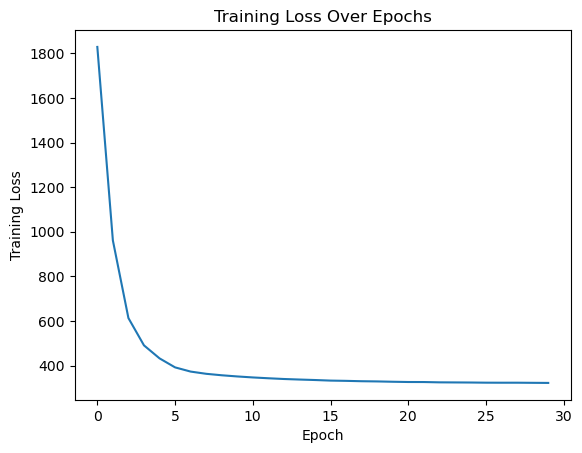

In [163]:
# Implement the training loop here
if not skip_training:
    # Create network
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    gnn = GNN()
    gnn.to(device)
    epochs = 30
    optimizer = optim.Adam(gnn.parameters(), lr=0.001)
    classification_loss = nn.CrossEntropyLoss()
    length = len(trainloader)
    plot_losses = []
    for epoch in range(epochs):
        total_loss = 0

        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}')

        for k, (inputs, targets, src_ids, dst_ids) in enumerate(trainloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            src_ids = src_ids.to(device)
            dst_ids = dst_ids.to(device)

            optimizer.zero_grad()

            loss = 0
            outputs = gnn(inputs, src_ids, dst_ids)

            if (k == 0 or (k + 1) % 100 == 0 or k == length - 1) and (epoch == 0 or (epoch + 1) % 10 == 0):
                print(f'Iteration {k+1}/{length}')

            for i in range(gnn.n_iters):
                this_loss = classification_loss(outputs[i], targets)
                loss += this_loss
                if i == gnn.n_iters - 1:
                    last_loss = this_loss.item()
                if (epoch == 0 or (epoch + 1) % 10 == 0) and (k == 0 or (k + 1) % 100 == 0 or k == length - 1):
                    print(f'GNN Iteration {i+1}/{gnn.n_iters}, Loss: {this_loss.item():.4f}')
                    
            loss = loss / gnn.n_iters
            loss.backward()
            optimizer.step()

            if (epoch == 0 or (epoch + 1) % 10 == 0) and (k == 0 or (k + 1) % 100 == 0 or k == length - 1):
                print(f'Average Loss: {loss.item():.4f}')
                print('\n')

            total_loss += loss.item() * 16 # batch_size

        total_loss = total_loss / length
        plot_losses.append(total_loss)
        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Training Loss: {total_loss:.4f}')
        print(f'Last Classification Loss: {last_loss:.4f}')
        print(f'Test Accuracy: {fraction_of_solved_puzzles(gnn, testloader):.4f}')
        print('\n')

    
    print('Training done!')
    plt.plot(range(epochs), plot_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()


In [164]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(gnn, '1_gnn.pth', confirm=False)

Model saved to 1_gnn.pth.


In [165]:
skip_training = True
device = torch.device('cpu')

In [166]:
if skip_training:
    gnn = GNN()
    tools.load_model(gnn, '1_gnn.pth', device)

Model loaded from 1_gnn.pth.


## Evaluate the trained model

In [167]:
# Get graph iterations for some test puzzles
with torch.no_grad():
    inputs, targets, src_ids, dst_ids = next(iter(testloader))
    inputs, targets = inputs.to(device), targets.to(device)
    src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

    batch_size = inputs.size(0) // 81
    outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, n_nodes, 9]

    solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)
    final_solution = solution[-1].argmax(dim=3)
    print('Solved puzzles in the current mini-batch:')
    print((final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1))

Solved puzzles in the current mini-batch:
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


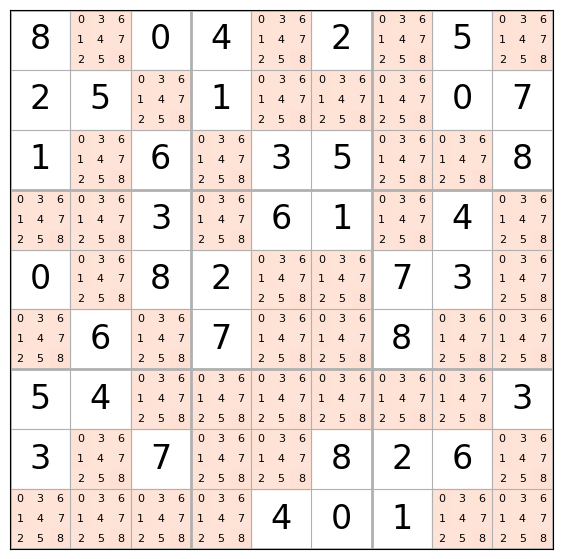

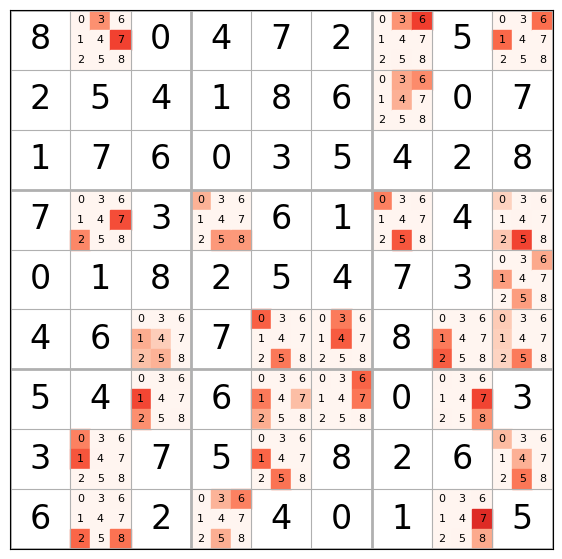

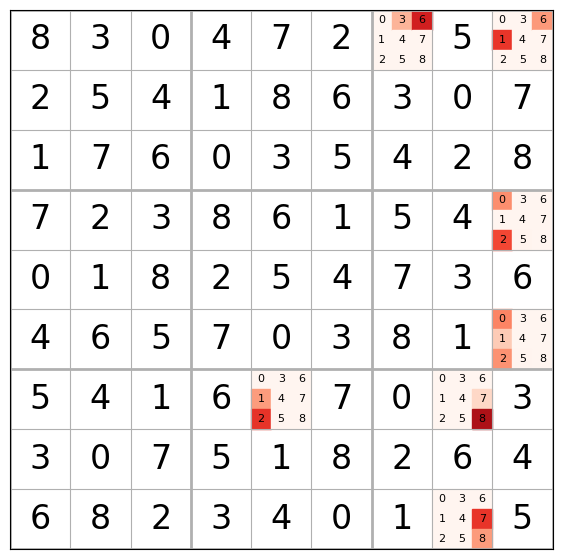

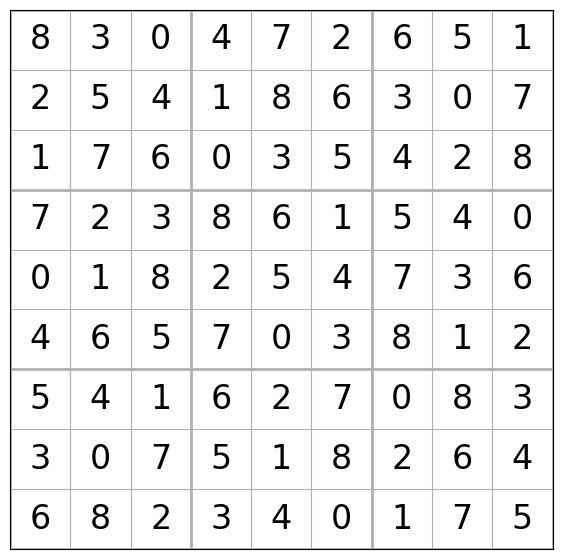

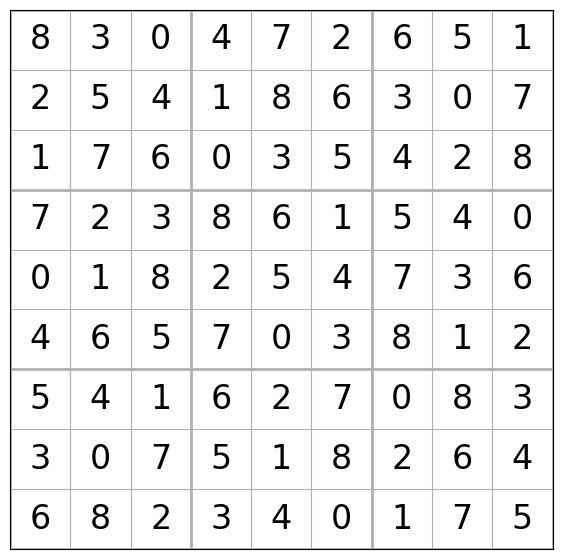

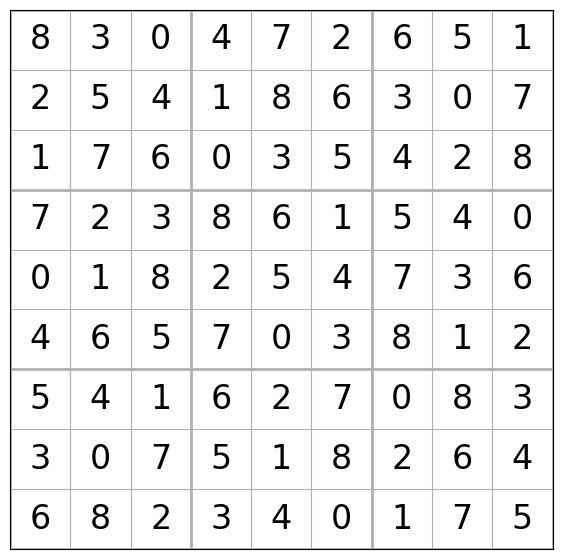

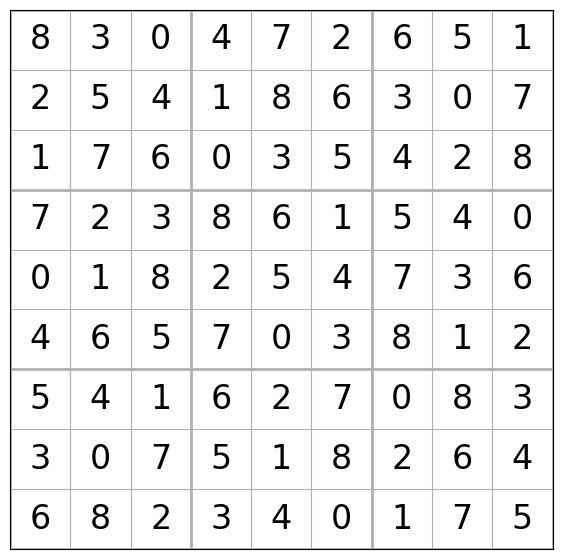

In [168]:
# Visualize graph iteration for one of the puzzles
ix = 0
for i in range(gnn.n_iters):
    tools.draw_sudoku(solution[i, 0], logits=True)

In [169]:
fraction_solved = fraction_of_solved_puzzles(gnn, testloader)
print(fraction_solved)
assert fraction_solved > .93, "Poor accuracy ({:.3f})".format(fraction_solved)
print('Success')

1.0
Success


<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

In this exercise, we learned how to train a simple graph neural network.

Note that the network learned to solve Sudoku puzzles without being explicitly told about the rules of the game. It learned to solve the puzzle from the training examples. We helped the network by telling which objects (cells) are related to each other but we did not specify the exact type of the relations.